# LSTM  para predecir a los pasajeros de las aerolíneas internacionales

In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import time
import pandas as pd
from keras.models import Sequential
from keras.layers import Bidirectional 
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

C:\Users\Jergb\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# convertimos un array de valores en una matriz de conjuntos de datos
Con esto tenemos la salida a n muestras siguientes

In [2]:
# convertimos un array de valores en una matriz de conjuntos de datos
def crear_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# Se define una semilla constante para controlar la estabilidad del modelo.
Con esto se garantiza que el modelo se entrene siempre con la misma secuencia de numeros aleatorios.

In [3]:
numpy.random.seed(5)

# cargamos el conjunto de datos

(4559, 1)

(4559, 1)

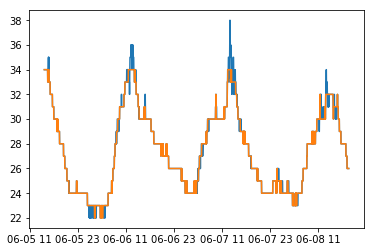

In [4]:
datos = pd.read_csv('ajustado.csv', parse_dates=True,index_col=0)
d_prueba = pd.read_csv('nodo2_periodo3.csv', parse_dates=True,index_col=0)
#d_prueba = d_prueba.drop(columns=['HORA'])
data = pd.DataFrame(datos.loc[:,'TEMPERATURA'])
probar = pd.DataFrame(d_prueba.loc[:,'TEMPERATURA'])
#data = data.astype('float32')
display(data.shape,probar.shape)
plt.plot(probar)
plt.plot(data)

In [5]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
probar = scaler.fit_transform(probar)

In [6]:
# dividimos entre entranmiento y test
ld = len(data)
entrenar = data[0:int(ld * 0.7)]
validar = data[int(ld * 0.7)::]

# Se crean secuencias de observaciones pasadas para  los conjuntos de entrenamiento, validación y prueba
- El modelo aprenderá a hacer predicciones basado en la cantidad de secuencias que se definan.

In [ ]:
# remodelamos X=t y Y=t+1
ventana = 5
neuronas = 2
entrenarX, entrenarY = crear_dataset(entrenar, ventana)
validarX, validarY = crear_dataset(validar, ventana)
probarX, probarY = crear_dataset(probar, ventana)

In [8]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
# Se reordena data.shape[0], data.shape[1], de manera que cada secuencia predice el siguiente paso de tiempo 
entrenarX = numpy.reshape(entrenarX, (entrenarX.shape[0], entrenarX.shape[1],1))
validarX = numpy.reshape(validarX, (validarX.shape[0], validarX.shape[1],1))
probarX = numpy.reshape(probarX, (probarX.shape[0], probarX.shape[1],1))

In [9]:
#creamos la LSTM network
# Se define el batch_size tamaño de muestras
batch_size = 1
# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
# stateful = True permite que la red entrene con todos los lotes de manera secuencial y no por separado.
# se ingresa el tamaño de muestras de entrada.
#model.add(Bidirectional(LSTM(50, batch_input_shape=(batch_size, ventana),stateful = True)))
model.add(LSTM(neuronas, batch_input_shape=(batch_size, ventana, 1), stateful=True, return_sequences=True))
model.add(LSTM(neuronas, batch_input_shape=(batch_size, ventana, 1), stateful=True))
# devuelve una secuencia de vectores de dimensión 50
model.add(Dense(1))
# evaluar la exactitud de las predicciones de un modelo a través del error de la raíz cuadrada de la media (RMSE)
# El error de entrenamiento mide qué tan bien ajusta los datos de entrenamiento tu modelo
#El error cuadrático medio (MSE) puede ser difícil de interpretar; es por esto que generalmente observamos el error 
# de la raíz cuadrada de la media (RMSE) en su lugar. Una propiedad interesante del RMSE es que se puede interpretar 
# en la misma escala que los objetivos originales
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

tiempo = time.time()

# el bucle de ajuste permite que la red mantenga las salidas de las secuencias en cada iteración.
ajuste = []
for i in range(10):
    ajuste.append(model.fit(entrenarX, entrenarY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False))
    model.reset_states()
timeup = time.time() - tiempo

Epoch 1/1
 - 13s - loss: 0.0167 - acc: 0.0549
Epoch 1/1
 - 12s - loss: 0.0017 - acc: 0.0719
Epoch 1/1
 - 16s - loss: 0.0012 - acc: 0.0722
Epoch 1/1
 - 17s - loss: 0.0011 - acc: 0.0722
Epoch 1/1
 - 15s - loss: 0.0010 - acc: 0.0722
Epoch 1/1
 - 13s - loss: 0.0010 - acc: 0.0722
Epoch 1/1
 - 13s - loss: 0.0010 - acc: 0.0722
Epoch 1/1
 - 13s - loss: 0.0010 - acc: 0.0722
Epoch 1/1
 - 14s - loss: 0.0011 - acc: 0.0722
Epoch 1/1
 - 12s - loss: 0.0010 - acc: 0.0722


In [10]:
# hacemos las predicciones, se anexa batch=batch_size debido a que seestá trbajando con estados
entrenar_predic = model.predict(entrenarX, batch_size=batch_size)
validar_predic = model.predict(validarX, batch_size=batch_size)
probar_predic = model.predict(probarX, batch_size=batch_size)

In [11]:
# invertimos las predicciones
entrenar_predic = scaler.inverse_transform(entrenar_predic)
entrenarY = scaler.inverse_transform([entrenarY])
validar_predic = scaler.inverse_transform(validar_predic)
validarY = scaler.inverse_transform([validarY])
probar_predic = scaler.inverse_transform(probar_predic)
probarY = scaler.inverse_transform([probarY])

In [12]:
# calculamos el error rms
r_entrenamiento = math.sqrt(mean_squared_error(entrenarY[0], entrenar_predic[:,0]))
print('Resultado del entrenamiento: %.2f RMSE' % (r_entrenamiento))
r_validacion = math.sqrt(mean_squared_error(validarY[0], validar_predic[:,0]))
print('Resultado de la validación: %.2f RMSE' % (r_validacion))
r_prueba = math.sqrt(mean_squared_error(probarY[0], probar_predic[:,0]))
print('Resultado de la prueba: %.2f RMSE' % (r_prueba))

Resultado del entrenamiento: 2.85 RMSE
Resultado de la validación: 2.12 RMSE
Resultado de la prueba: 1.74 RMSE


In [13]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = numpy.empty_like(data)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[ventana:len(entrenar_predic)+ventana, :] = entrenar_predic

In [14]:
# predicciones del test de cambio para plotear
vPredictPlot = numpy.empty_like(data)
vPredictPlot[:, :] = numpy.nan
vPredictPlot[len(entrenar_predic)+(ventana*2)+1:len(data)-1, :] = validar_predic

In [15]:
# predicciones del test de cambio para plotear
testPredictPlot = numpy.empty_like(d_prueba)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[ventana:len(probar_predic)+ventana, :] = probar_predic

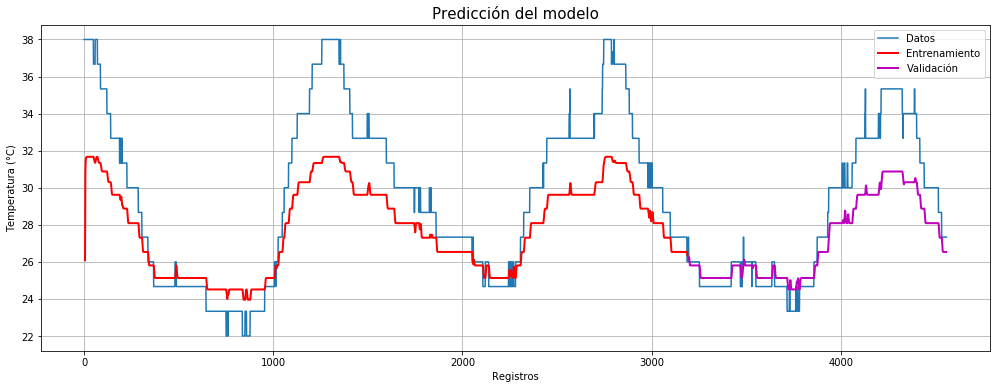

In [16]:
plt.figure(figsize=(17,6))
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(vPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Entrenamiento', 'Validación'))
plt.grid(True)
plt.title("Predicción del modelo", fontsize = 15)
plt.xlabel("Registros", fontsize = 10)
plt.ylabel("Temperatura (°C)", fontsize = 10)
plt.show()

In [ ]:
d_prueba = pd.read_csv('nodo2_periodo2.csv', parse_dates=True,index_col=0)

probar = pd.DataFrame(d_prueba.loc[:,'TEMPERATURA'])
plt.figure(figsize=(17,6))
# normalizamos el conjunto de datos

scaler = MinMaxScaler(feature_range=(0, 1))
probar_e = pd.DataFrame(scaler.fit_transform(probar)).values
probarX, probarY = crear_dataset(probar_e, ventana)

probarX = numpy.reshape(probarX, (probarX.shape[0], probarX.shape[1], 1))
probar_predic = model.predict(probarX, batch_size=batch_size)

probar_predic = scaler.inverse_transform(probar_predic)
probarY = scaler.inverse_transform([probarY])

r_prueba = math.sqrt(mean_squared_error(probarY[0], probar_predic[:,0]))
print('Resultado de la prueba con atípicos: %.2f RMSE' % (r_prueba))
testPredictPlot = numpy.empty_like(probar)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[ventana:len(probar_predic)+ventana, :] = probar_predic
plt.plot(probar.values)
plt.plot(probar_predic,'r.')

In [20]:
datax

NameError: name 'datax' is not defined

#valores = pd.DataFrame({'t':datos.iloc[58:64,-1]})
valores = pd.DataFrame({'t':[33,33,33,33,33,33,\
                             33,33,33,33,33,33,33,33,33,33,33,33,\
                             33,33,33,33,34,34,34,34,34,34,34,67,34,34]})
inte = [[x] for x in valores.t]
print(inte)
probar = pd.DataFrame(scaler.fit_transform(inte)).values
probarX, probarY = crear_dataset(probar, ventana)

probarX = numpy.reshape(probarX, (probarX.shape[0], probarX.shape[1], 1))
probar_predic = model.predict(probarX, batch_size=batch_size)
probar_predic = scaler.inverse_transform(probar_predic)
r = pd.DataFrame({'t+%d'%ventana:[int(x) for x in probar_predic]})
pd.concat([valores,r],axis=1)


# Resumen
- ventana = 1; neuronas = 2:  
Resultado del entrenamiento: 0.75 RMSE  
Resultado de la validación: 0.54 RMSE  
Resultado de la prueba: 0.58 RMSE 
Resultado de la prueba con atípicos: 7.20 RMSE  
Total params: 75  
Trainable params: 75  
Non-trainable params: 0  
Tiempo:  11.83968871831894 minutos

---
- ventana = 1; neuronas = 4:  
Resultado del entrenamiento: 0.96 RMSE  
Resultado de la validación: 0.77 RMSE  
Resultado de la prueba: 0.84 RMSE  
Resultado de la prueba con atípicos: 8.59 RMSE  
Total params: 245  
Trainable params: 245  
Non-trainable params: 0  
Tiempo:  10.938772861162821 minutos

---
- ventana = 1; neuronas = 6;  
Resultado del entrenamiento: 1.30 RMSE  
Resultado de la validación: 1.09 RMSE  
Resultado de la prueba: 1.11 RMSE  
Resultado de la prueba con atípicos: 10.71 RMSE  
Tiempo:  10.694780294100443 minutos  
Exactitud máxima: 0.04107870805895265  
Total params: 511  
Trainable params: 511  
Non-trainable params: 0  

--
- ventana = 5; neuronas 2

Tiempo:  2.2921563585599265 minutos
Exactitud máxima: 0.07221350078492936
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 5, 2)                 32        
_________________________________________________________________
lstm_2 (LSTM)                (1, 2)                    40        
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    3         
Total params: 75
Trainable params: 75
Non-trainable params: 0
_________________________________________________________________


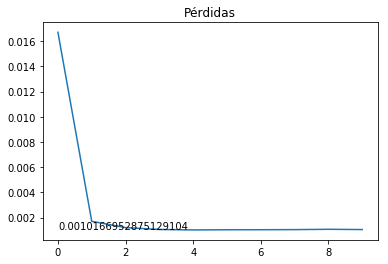

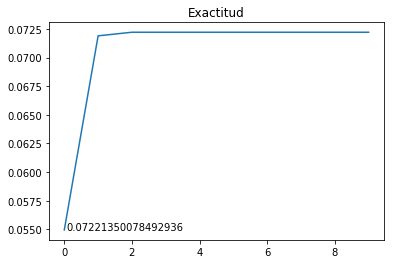

In [18]:
print('Tiempo: ',timeup/60, 'minutos')
acc =[x.history['acc'] for x in ajuste]
loss = [x.history['loss'] for x in ajuste]
plt.plot(loss)
plt.title('Pérdidas')
plt.text(loss[-1][0],loss[-1][0],min(loss)[0])
plt.figure()
plt.plot(acc)
plt.title('Exactitud')
plt.text(acc[0][0],acc[0][0],max(acc)[0])
print('Exactitud máxima:', max(acc)[0])
model.summary()

In [19]:
acc[0]

[0.054945054945054944]